In [1]:
from torchvision import models, transforms, datasets
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
train_data_path = 'asl_alphabet_train/asl_alphabet_train/'

Определим трансформации для тестового и обучающего датасета.



In [3]:
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [15]:
import PIL
import torch
from torch import nn
from PIL import Image
from torchvision.transforms import v2
import matplotlib.pyplot as plt

transform = v2.Compose([
    v2.ToPILImage(),  # Assuming you're starting with a tensor
    v2.RandomResizedCrop(size=(226, 226), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5], std=[0.5])  # Gray normalization
])
im1 = transform(Image.open("asl_alphabet_train\\asl_alphabet_train\A\A1.jpg"))
im2 = transform(Image.open("asl_alphabet_train\\asl_alphabet_train\A\A2.jpg"))
imconv = nn.LeakyReLU()(nn.Conv2d(3,64, kernel_size=3,bias = False)(im1))
# imadd = torch.add(im1,im2)
# imcat = torch.cat(imadd,imconv,1)
# imcat.show()
plt.imshow(imconv.detach().numpy().permute(1, 2, 0)  )

c:\Users\hp\anaconda3\envs\twostream\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


AttributeError: 'numpy.ndarray' object has no attribute 'permute'

Загрузим датасет и поделим его на обучение и валидацию.



In [4]:
# %%time
train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)

CPU times: user 114 ms, sys: 24.3 ms, total: 138 ms
Wall time: 137 ms


In [5]:
# %%time
val_dataset = datasets.ImageFolder(train_data_path, transform=test_transforms)

CPU times: user 106 ms, sys: 23.9 ms, total: 130 ms
Wall time: 129 ms


In [6]:
torch.manual_seed(1)
# num_train_samples = len(train_dataset)
num_train_samples = 20000

val_split = 0.2
split = int(num_train_samples * val_split)
indices = torch.randperm(num_train_samples)


train_subset = torch.utils.data.Subset(train_dataset, indices[split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[:split])

len(train_subset), len(val_subset)

(16000, 4000)

In [7]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=batch_size,
    shuffle=False
)

In [8]:
classes = train_dataloader.dataset.dataset.classes

Можем проверить, как работает dataloader.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224]) torch.Size([32])
Ground Truth C


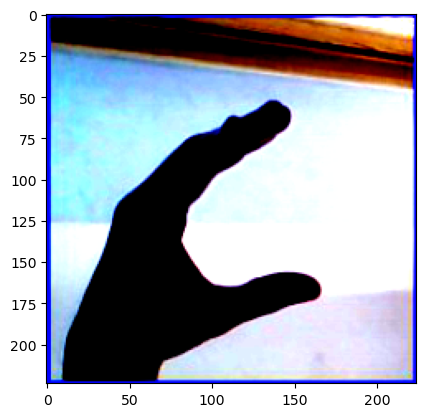

In [9]:
for img, label in train_dataloader:
    print(img.shape, label.shape)
    print(f'Ground Truth {classes[label[0]]}')
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [10]:
resnet = models.resnet50(pretrained=True)
# summary(resnet.to(device), input_size=(3, 224, 224))

/home/nyanmaruk/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nyanmaruk/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/nyanmaruk/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
  5%|▍         | 4.61M/97.8M [00:05<01:41, 963kB/s] 


KeyboardInterrupt: 

Заморозим претренерованные слои, чтобы они не обучались.



In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
resnet

In [ ]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(classes))
resnet.fc = fc

In [ ]:
resnet

Зададим функцию потерь и оптимизатор.

In [ ]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

Обучаем модель.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
from time import time
from tqdm import tqdm


def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

In [ ]:
print_every = 50
num_epoch = 2

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    print_every=print_every,
    num_epoch=num_epoch
)

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

Инференс

In [ ]:
from pathlib import Path
from PIL import Image


test_data_path = Path('../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/')


class ASLTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None):
        super().__init__()
        
        self.transforms = transforms
        self.imgs = sorted(list(Path(root_path).glob('*.jpg')))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        
        label = img_path.parts[-1].split('_')[0]
        if self.transforms:
            img = self.transforms(img)
        
        return img, label

In [ ]:
test_dataset = ASLTestDataset(test_data_path, transforms=test_transforms)

columns = 7
row = round(len(test_dataset) / columns)

fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

i, j = 0, 0
for img, label in test_dataset:
    img = torch.Tensor(img)
    img = img.to(device)
    resnet.eval()
    prediction = resnet(img[None])

    ax[i][j].imshow(img.cpu().permute(1, 2, 0))
    ax[i][j].set_title(f'GT {label}. Pred {classes[torch.max(prediction, dim=1)[1]]}')
    ax[i][j].axis('off')
    j += 1
    if j == columns:
        j = 0
        i += 1
        
plt.show()